In [4]:
import numpy as np
from astropy.io import fits
import pdb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib
from astropy.visualization import hist
from datetime import datetime
from pathlib import Path
import os
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D,Gaussian2D,Polynomial2D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData, StdDevUncertainty
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table
from astropy.coordinates import SkyCoord
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
import colorcet as cc
import cmasher as cmr
import astropy.units as u

In [2]:
from astropy.stats import mad_std

In [3]:
phot_tutorial_dir = '/Users/sofimar/Software/py/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [7]:
reduced_dir = '/Users/sofimar/Desktop/Observational Astro/Reduced/'
Hadir = reduced_dir+'Ha/'
Udir = reduced_dir+'U/'
Bdir = reduced_dir+'B/'
Vdir = reduced_dir+'V/'
Rdir = reduced_dir+'R/'
Idir = reduced_dir+'I/'

# 1) ADU vs. Time

- I am using a074-80 for linearity test

- **Exposure Times:** 2, 4, 8, 16, 32, 64, 128

- My ADU count will be the mean pixel value of the same saturated star in each frame

In [5]:
x = 622.53713
y = 1711.2508

pos = [(x,y)]

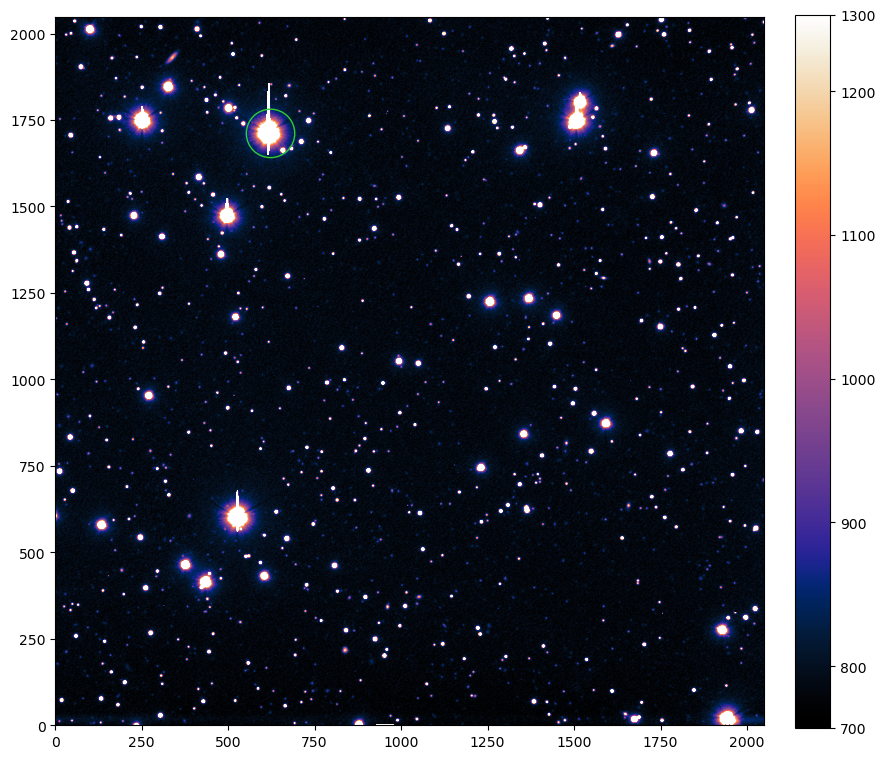

In [53]:
a080 = fits.open(Vdir+'a080otzf.fits')
ap = CircularAperture(pos, 70)

show_image(a080[0].data, cmap=cmr.torch)
ap.plot(color='limegreen')

Green ring denotes the saturated star I am using

(1655.0, 1780.0)

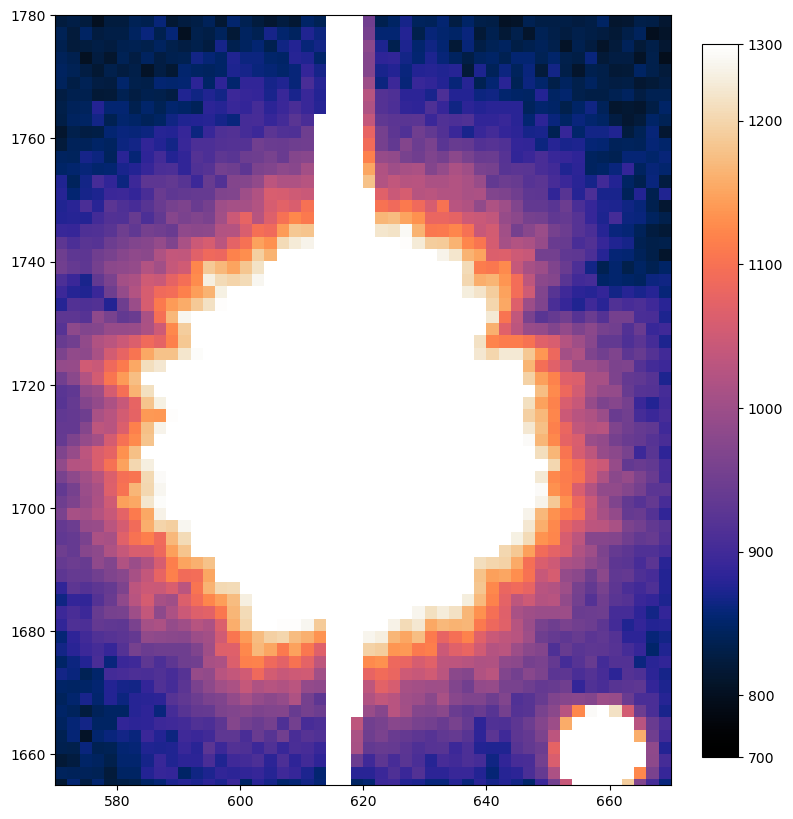

In [59]:
show_image(a080[0].data, cmap=cmr.torch)
plt.xlim(570,670)
plt.ylim(1655,1780)

I will calculate the median of rows[1654:1780] and columns[569:670]

In [56]:
lintest  = ImageFileCollection(location=Vdir, 
                               filenames=['a074otzf.fits', 'a075otzf.fits', 'a076otzf.fits', 
'a077otzf.fits', 'a078otzf.fits', 'a079otzf.fits', 'a080otzf.fits'])

In [60]:
t = np.array([2,4,8,16,32,64,128])
med_adu = np.zeros(7)
med_star = np.zeros(7)
for i in range(7):
    img = fits.open(Vdir+lintest.summary['file'][i])
    med_adu[i] = np.median(img[0].data)
    med_star[i] = np.mean(img[0].data[1654:1780, 569:670])

Text(0.5, 1.0, 'Saturated Star')

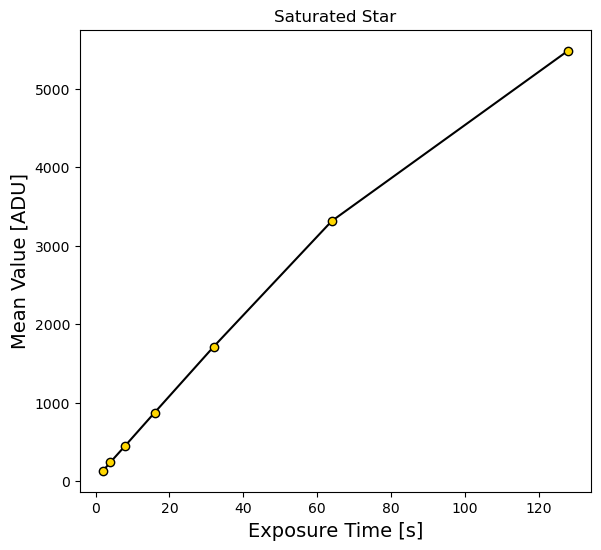

In [61]:
fig = plt.figure(figsize=(6.6,6))

plt.plot(t, med_star, color='black', zorder=0)
plt.scatter(t, med_star, color='gold', ec='black')
plt.xlabel('Exposure Time [s]', fontsize=14)
plt.ylabel('Mean Value [ADU]', fontsize=14)
plt.title('Saturated Star')

At the longest exposure (128 s), the CCD begins losing the directly proportional relationship between ADU output per pixel and exposure time.

# 2) Aperture Sizes
- I'm using a082

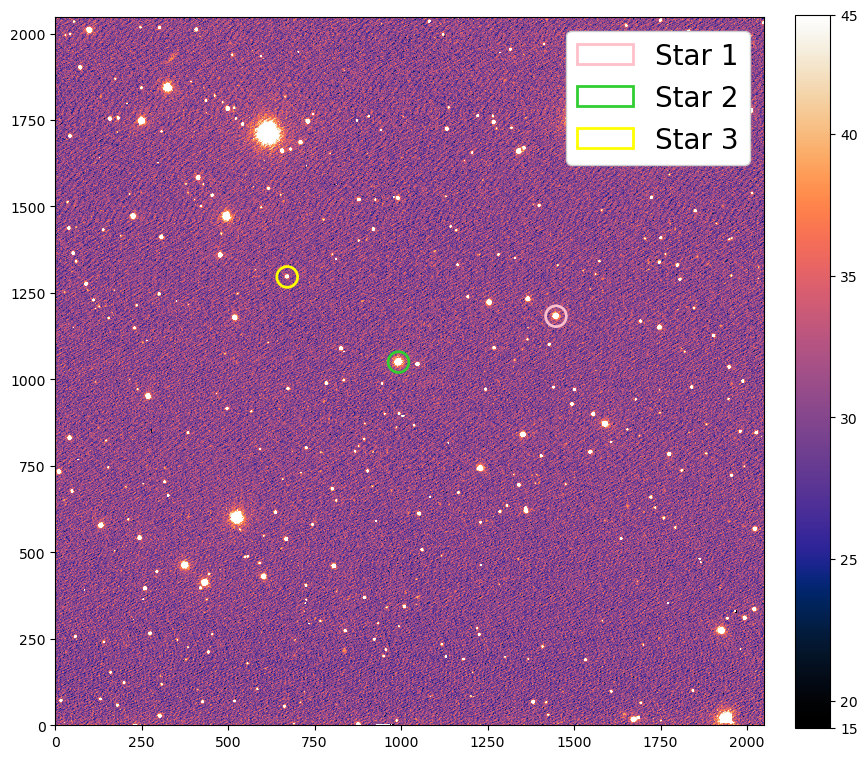

In [102]:
a082 = fits.open(Udir+'a082otzf.fits')
ap1 = CircularAperture([(1447.8153, 1182.66)], r=30)
ap2 = CircularAperture([(992.5, 1050)], r=30)
ap3 = CircularAperture([(670.76, 1296.296)], r=30)
show_image(a082[0].data, cmap=cmr.torch)
ap1.plot(color='pink', linewidth=2, label='Star 1')
ap2.plot(color='limegreen', linewidth=2, label='Star 2')
ap3.plot(color='yellow', linewidth=2, label='Star 3')
plt.legend(fontsize=20, framealpha=1)

### Star 1
- **Medium Bright**

- Center: (1447.8153, 1182.66)

### Star 2

- **Very Bright**

- Center: (992.5, 1050)

### Star 3
- **Faint**

- Center: (670.76, 1296.296)

In [99]:
pos1 = [(1447.8153, 1182.66)]
pos2 = [(992.5, 1050)]
pos3 = [(670.76, 1296.296)]
pos = [pos1, pos2, pos3]

In [122]:
R = [1,2,4,7,10,20]
s2n = np.zeros((3,6))
for i in range(3):
    an = CircularAnnulus(pos[i], r_in=20, r_out=25)
    for j in range(6):
        ap = CircularAperture(pos[i], R[j])
        phot_table = aperture_photometry(a082[0].data, ap)
        phot_table_ = aperture_photometry(a082[0].data, an)
        T = phot_table['aperture_sum']
        T_ = phot_table_['aperture_sum']
        A = ap.area
        A_ = an.area
        B = T_/A_
        S = T - (A*B)
        sn = S/np.sqrt(S+(A*B))
        s2n[i,j] = sn
    
    

Text(0, 0.5, 'S/N')

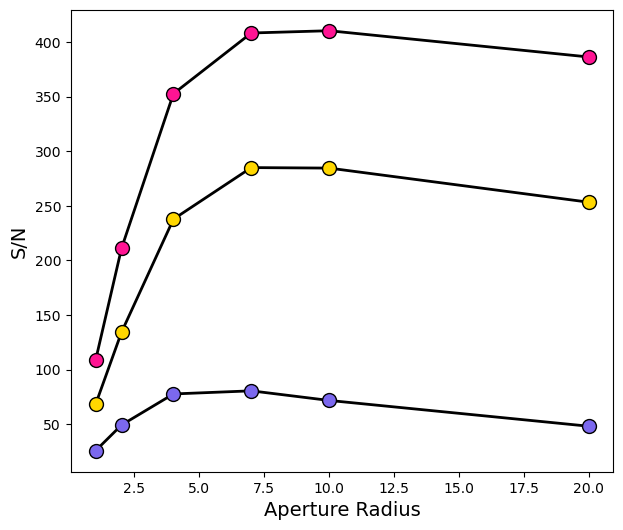

In [131]:
fig = plt.figure(figsize=(7,6))
plt.scatter(R, s2n[0], color='gold', ec='black', s=100)
plt.plot(R, s2n[0], color='black', zorder=0, linewidth=2)
plt.scatter(R, s2n[1], color='deeppink', ec='black', s=100)
plt.plot(R, s2n[1], color='black', zorder=0, linewidth=2)
plt.scatter(R, s2n[2], color='mediumslateblue', ec='black',  s=100)
plt.plot(R, s2n[2], color='black', zorder=0, linewidth=2)
plt.xlabel('Aperture Radius', fontsize=14)
plt.ylabel('S/N', fontsize=14)

#### Based on the plot above, an aperture radius of 7 is best.

# 3)

Coincidentally my Star 1 is Star D and my Star 2 is Star E from Landolt 1992.

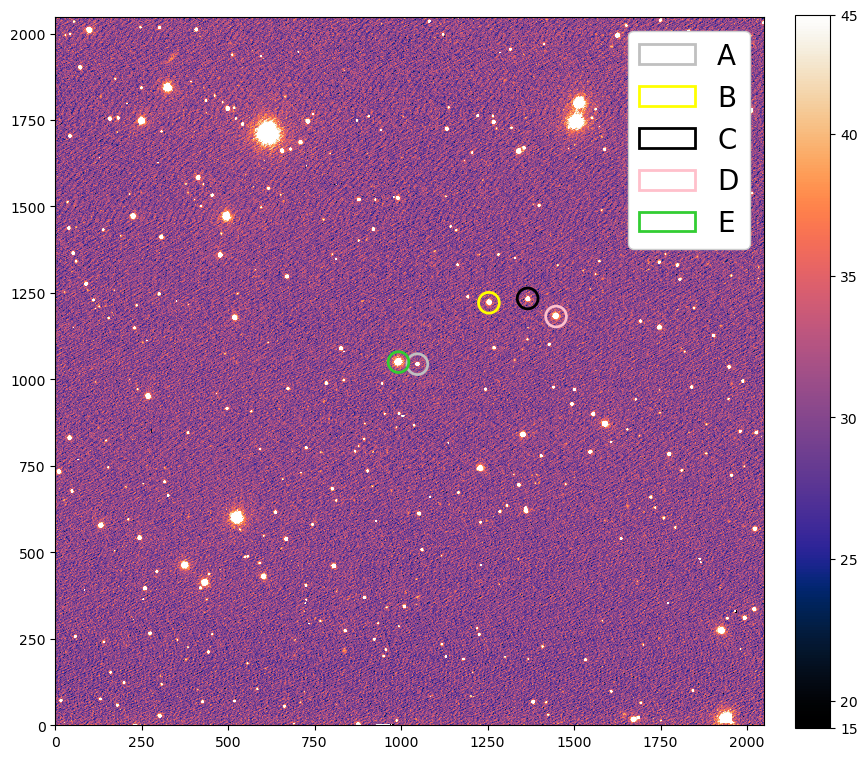

In [200]:
ap_A = CircularAperture(pos2, 30)
ap_B = CircularAperture([(1253.9254, 1221.5773)], 30)
ap_C = CircularAperture([(1365.8998,1234.0189)], 30)
ap_D = CircularAperture([(1448.0144, 1181.7642)], 30)
ap_E = CircularAperture([(1047, 1044)], 30)
show_image(a082[0].data, cmap=cmr.torch)
ap_E.plot(color='silver', label='A', linewidth=2)
ap_B.plot(color='yellow', label='B', linewidth=2)
ap_C.plot(color='black', label='C', linewidth=2)
ap_D.plot(color='pink', label='D', linewidth=2)
ap_A.plot(color='limegreen', label='E', linewidth=2)
plt.legend(fontsize=20, framealpha=1)

# 4-5) Instrumental Magnitude, Airmass, Extinction

m = -2.5log(S)

- I am ommitting X = 2.1ish because log says "don't use for photom?"

In [194]:
import pandas as pd

So I originally made a REALLY big dataframe and then decided that it wasn't too practical visually, but kept it because it helped me create smaller dataframes.

In [358]:
d = {'File': [['a082', 'a131', 'a203', 'a237'],
              ['a083', 'a133', 'a204', 'a239'],
              ['a085', 'a134', 'a206', 'a241'],
              ['a088', 'a136', 'a209', 'a244'],
              ['a089', 'a139', 'a211', 'a245']],
     'X': [[1.18, 1.24, 1.49, 2.15],
           [1.18, 1.24, 1.51, 2.19],
           [1.18, 1.24, 1.52, 2.21],
           [1.18, 1.24, 1.53, 2.23],
           [1.18, 1.24, 1.53, 2.26]],
      'Center A': [[(1047.8,1044.2), (989,1037), (982,1031), (894,1033)],
                  [(1047,1044), (988,1038), (982,1031), (895,1033)],
                  [(1046,1044), (989,1038), (981,1032), (895,1034)],
                  [(1044,1044), (988,1039), (982,1032), (896.7,1034.2)],
                  [(1042,1045), (987,1040), (980.83,1033.33), (895,1035)]],     
     'Center B': [[(1254.2,1220.6), (1195.4,1215.8), (1189,1209), (1100,1211)],
                  [(1253,1222), (1196,1216), (1189,1209), (1102,1211)],
                  [(1252,1222), (1196,1216), (1188,1210), (1102,1213)],
                  [(1250,1222), (1196,1217), (1189,1209), (1102.5,1212.5)],
                  [(1249,1223), (1194,1218), (1187.5,1210.83), (1102,1213)]],
     'Center C': [[(1367,1231.4), (1308.2,1225.4), (1301,1218), (1213,1220)],
                  [(1365,1232), (1307,1225), (1301,1219), (1214,1221)],
                  [(1365,1232), (1308,1226), (1300,1219), (1214,1222)],
                  [(1362,1232), (1308,1227), (1300,1219), (1214.2,1221.7)],
                  [(1362,1233), (1306,1228), (1300,1220.83), (1214,1223)]],
     'Center D': [[(1446.2,1182.2), (1388.6,1176.2), (1382,1168), (1293,1170)],
                  [(1446,1183), (1387,1176), (1381,1170), (1294,1172)],
                  [(1445,1182), (1388,1176), (1381,1170), (1294,1173)],
                  [(1443,1182), (1387,1177), (1381,1170), (1295,1173.3)],
                  [(1442,1184), (1386, 1179), (1380,1171.67), (1294,1174)]],
      'Center E': [[(991.4,1049), (933.8,1044.2), (927,1036), (838,1038)],
                  [(991,1051), (933,1044), (926,1037), (839,1040)],
                  [(990,1050), (933,1044), (926.6,1038.2), (839,1040)],
                  [(988,1050), (932,1045), (926,1038), (840,1040.83)],
                  [(987,1051), (931,1046), (925,1039.17), (839,1042)]]}

In [359]:
df = pd.DataFrame(data=d, index=['U','B','V','R','I'])

Then, I made a dataframe for the standard stars in Landolt (1992)

In [327]:
v = np.array([15.256, 12.969, 13.229, 13.691, 14.397])
b_v = np.array([0.873, 1.081, 1.134, 0.535, -0.192])
u_b = np.array([0.320, 1.007, 1.138, -0.025, -0.974])
v_r = np.array([0.505, 0.590, 0.618, 0.324, -0.093])
r_i = np.array([0.511, 0.502, 0.523, 0.327, -0.116])
v_i = np.array([1.015, 1.090, 1.138, 0.650, -0.212])

# Deriving magnitudes
b = b_v+v
u = u_b+b
r = -v_r+v
I = -v_i+v

In [328]:
Landlot_dic = {'Star': ['A', 'B', 'C', 'D', 'E'],
               'U mag': u,
               'B mag': b,
               'V mag': v,
               'R mag': r,
               'I mag': I,
               'B - V': b_v,
               'U - B': u_b,
               'V - R': v_r,
               'R - I': r_i,
               'V - I': v_i}

df_L = pd.DataFrame(Landlot_dic)

In [329]:
df_L

Star   U mag   B mag   V mag   R mag   I mag  B - V  U - B  V - R  R - I  \
0    A  16.449  16.129  15.256  14.751  14.241  0.873  0.320  0.505  0.511   
1    B  15.057  14.050  12.969  12.379  11.879  1.081  1.007  0.590  0.502   
2    C  15.501  14.363  13.229  12.611  12.091  1.134  1.138  0.618  0.523   
3    D  14.201  14.226  13.691  13.367  13.041  0.535 -0.025  0.324  0.327   
4    E  13.231  14.205  14.397  14.490  14.609 -0.192 -0.974 -0.093 -0.116   

   V - I  
0  1.015  
1  1.090  
2  1.138  
3  0.650  
4 -0.212

## U filter

In [441]:
dU = {'File': ['a082', 'a131', 'a203', 'a237'],
      'X': [1.18, 1.24, 1.49, 2.15],
      'Center A': [(1047.8,1044.2), (989,1037), (982,1031), (894,1033)],
      'Center B': [(1254.2,1220.6), (1195.4,1215.8), (1189,1209), (1100,1211)],
      'Center C': [(1367,1231.4), (1308.2,1225.4), (1301,1218), (1213,1220)],
      'Center D': [(1446.2,1182.2), (1388.6,1176.2), (1382,1168), (1293,1170)],
      'Center E': [(991.4,1049), (933.8,1044.2), (927,1036), (838,1038)]}

dUf = pd.DataFrame(data=dU)

In [222]:
def m(df_, star, dir_):
    f = df_['File']
    c = df_[star]
    m_array = np.zeros(4)
    for i in range(4):
        ap = CircularAperture([c[i]], r=7)
        an = CircularAnnulus([c[i]], r_in=20, r_out=25)

        frame = fits.open(dir_+str(f[i])+'otzf.fits')
        phot = aperture_photometry(frame[0].data, ap)
        phot_= aperture_photometry(frame[0].data, an)
        T = phot['aperture_sum']
        T_ = phot_['aperture_sum']
        A = ap.area
        A_ = an.area
        B = T_/A_
        S = T - (A*B)
        # print(S)
        ins_mag = -2.5*np.log10(S)
        m_array[i] = ins_mag
    return m_array

In [223]:
U_a = m(df_=dUf, star='Center A', dir_=Udir)

In [225]:
U_b = m(df_=dUf, star='Center B', dir_=Udir)
U_c = m(df_=dUf, star='Center C', dir_=Udir)
U_d = m(df_=dUf, star='Center D', dir_=Udir)
U_e = m(df_=dUf, star='Center E', dir_=Udir)

In [458]:
dUf['m_A'] = U_a
dUf['m_B'] = U_b
dUf['m_C'] = U_c
dUf['m_D'] = U_d
dUf['m_E'] = U_e

(array([-13.5, -13. , -12.5, -12. , -11.5, -11. , -10.5, -10. ,  -9.5]),
 [Text(0, -13.5, '−13.5'),
  Text(0, -13.0, '−13.0'),
  Text(0, -12.5, '−12.5'),
  Text(0, -12.0, '−12.0'),
  Text(0, -11.5, '−11.5'),
  Text(0, -11.0, '−11.0'),
  Text(0, -10.5, '−10.5'),
  Text(0, -10.0, '−10.0'),
  Text(0, -9.5, '−9.5')])

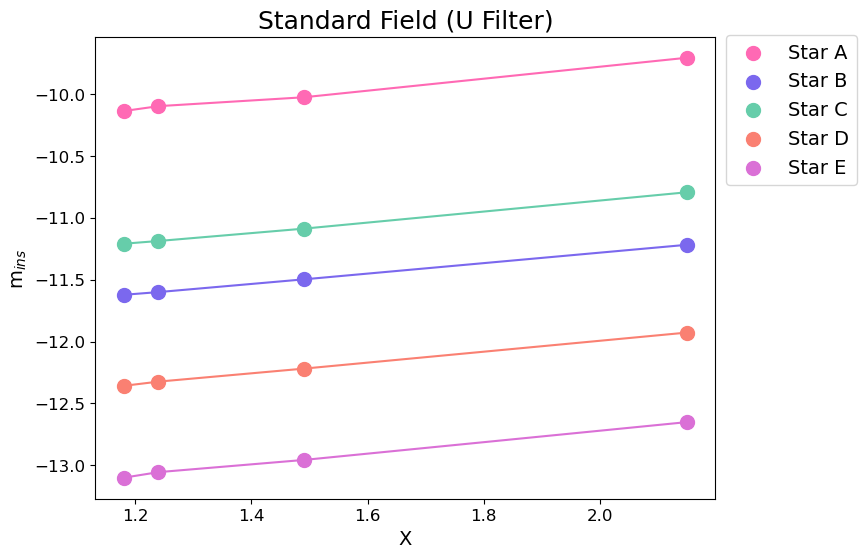

In [259]:
plt.figure(figsize=(8,6))
plt.scatter(dUf['X'], U_a, color='hotpink', label='Star A', s=100)
plt.plot(dUf['X'], U_a, color='hotpink')
plt.scatter(dUf['X'], U_b, color='mediumslateblue', label='Star B', s=100)
plt.plot(dUf['X'], U_b, color='mediumslateblue')
plt.scatter(dUf['X'], U_c, color='mediumaquamarine', label='Star C', s=100)
plt.plot(dUf['X'], U_c, color='mediumaquamarine')
plt.scatter(dUf['X'], U_d, color='salmon', label='Star D', s=100)
plt.plot(dUf['X'], U_d, color='salmon')
plt.scatter(dUf['X'], U_e, color='orchid', label='Star E', s=100)
plt.plot(dUf['X'], U_e, color='orchid')
plt.legend(fontsize=14, bbox_to_anchor=(1.001,1.024))
plt.title('Standard Field (U Filter)', fontsize=18)
plt.xlabel('X', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('m$_{ins}$', fontsize=14)
plt.yticks(fontsize=12)

In [289]:
from astropy.modeling.models import Linear1D
model = Linear1D()
fitter = fitting.LinearLSQFitter()


In [330]:
dmU_a = U_a - df_L['U mag'][0]
dmU_b = U_b - df_L['U mag'][1]
dmU_c = U_c - df_L['U mag'][2]
dmU_d = U_d - df_L['U mag'][3]
dmU_e = U_e - df_L['U mag'][4]

U_m_lob_a = fitter(model, dUf['X'], dmU_a) 
U_m_lob_b = fitter(model, dUf['X'], dmU_b)
U_m_lob_c = fitter(model, dUf['X'], dmU_c)
U_m_lob_d = fitter(model, dUf['X'], dmU_d)
U_m_lob_e = fitter(model, dUf['X'], dmU_e) 

In [487]:
dUf['K_A'] = U_m_lob_a.slope[0]
dUf['K_B'] = U_m_lob_b.slope[0]
dUf['K_C'] = U_m_lob_c.slope[0]
dUf['K_D'] = U_m_lob_d.slope[0]
dUf['K_E'] = U_m_lob_e.slope[0]

(array([-26.8, -26.6, -26.4, -26.2, -26. , -25.8]),
 [Text(0, -26.8, '−26.8'),
  Text(0, -26.6, '−26.6'),
  Text(0, -26.400000000000002, '−26.4'),
  Text(0, -26.2, '−26.2'),
  Text(0, -26.0, '−26.0'),
  Text(0, -25.8, '−25.8')])

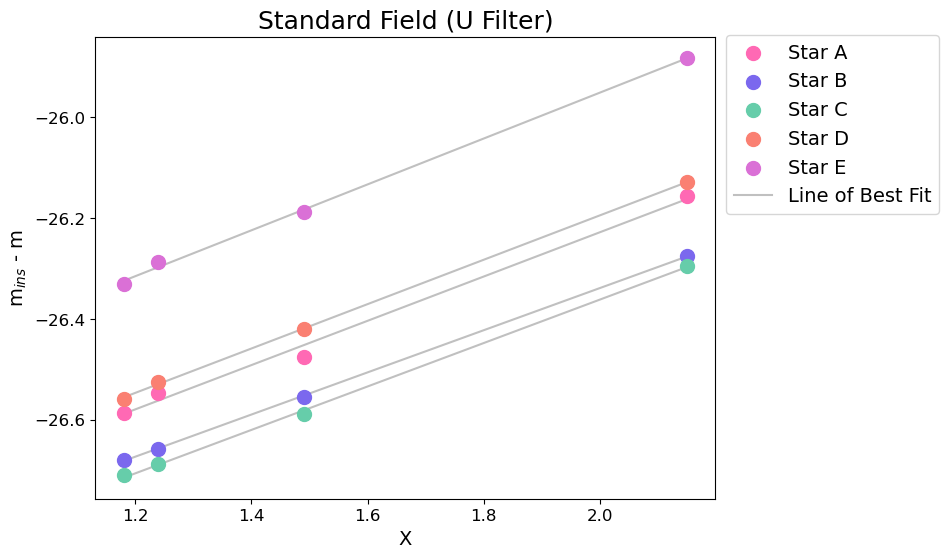

In [331]:
plt.figure(figsize=(8,6))
plt.scatter(dUf['X'], dmU_a, color='hotpink', label='Star A', s=100)
plt.plot(dUf['X'], U_m_lob_a(dUf['X']), color='silver', zorder=0)
plt.scatter(dUf['X'], dmU_b, color='mediumslateblue', label='Star B', s=100)
plt.plot(dUf['X'], U_m_lob_b(dUf['X']), color='silver', zorder=0)
plt.scatter(dUf['X'], dmU_c, color='mediumaquamarine', label='Star C', s=100)
plt.plot(dUf['X'], U_m_lob_c(dUf['X']), color='silver', zorder=0)
plt.scatter(dUf['X'], dmU_d, color='salmon', label='Star D', s=100)
plt.plot(dUf['X'], U_m_lob_d(dUf['X']), color='silver', zorder=0)
plt.scatter(dUf['X'], dmU_e, color='orchid', label='Star E', s=100)
plt.plot(dUf['X'], U_m_lob_e(dUf['X']), color='silver', zorder=0, label='Line of Best Fit')
plt.legend(fontsize=14, bbox_to_anchor=(1.001,1.024))
plt.title('Standard Field (U Filter)', fontsize=18)
plt.xlabel('X', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)

In [488]:
dUf

File     X          Center A          Center B          Center C  \
0  a082  1.18  (1047.8, 1044.2)  (1254.2, 1220.6)    (1367, 1231.4)   
1  a131  1.24       (989, 1037)  (1195.4, 1215.8)  (1308.2, 1225.4)   
2  a203  1.49       (982, 1031)      (1189, 1209)      (1301, 1218)   
3  a237  2.15       (894, 1033)      (1100, 1211)      (1213, 1220)   

           Center D         Center E        m_a        m_A        m_B  \
0  (1446.2, 1182.2)    (991.4, 1049) -10.137416 -10.137416 -11.622148   
1  (1388.6, 1176.2)  (933.8, 1044.2) -10.097699 -10.097699 -11.600160   
2      (1382, 1168)      (927, 1036) -10.025945 -10.025945 -11.497324   
3      (1293, 1170)      (838, 1038)  -9.706317  -9.706317 -11.217806   

         m_C        m_D        m_E       K_A       K_B       K_C       K_D  \
0 -11.209347 -12.357807 -13.100180  0.439478  0.418438  0.431109  0.440434   
1 -11.187320 -12.323618 -13.055089  0.439478  0.418438  0.431109  0.440434   
2 -11.087621 -12.218717 -12.956604  0.439478  0.418438  0.431109  0.440434   
3 -10.793303 -11.927124 -12.650586  0.439478  0.418438  0.431109  0.440434   

        K_E  
0  0.455472  
1  0.455472  
2  0.455472  
3  0.455472

## B Filter

In [293]:
dB = {'File': ['a083', 'a133', 'a204', 'a239'],
      'X': [1.18, 1.24, 1.51, 2.19],
      'Center A': [(1047,1044), (988,1038), (982,1031), (895,1033)],
      'Center B': [(1253,1222), (1196,1216), (1189,1209), (1102,1211)],
      'Center C': [(1365,1232), (1307,1225), (1301,1219), (1214,1221)],
      'Center D': [(1446,1183), (1387,1176), (1381,1170), (1294,1172)],
      'Center E': [(991,1051), (933,1044), (926,1037), (839,1040)]}

dBf = pd.DataFrame(dB)

In [310]:
B_a = m(df_=dBf, star='Center A', dir_=Bdir)
B_b = m(df_=dBf, star='Center B', dir_=Bdir)
B_c = m(df_=dBf, star='Center C', dir_=Bdir)
B_d = m(df_=dBf, star='Center D', dir_=Bdir)
B_e = m(df_=dBf, star='Center E', dir_=Bdir)

In [460]:
dBf['m_A'] = B_a
dBf['m_B'] = B_b
dBf['m_C'] = B_c
dBf['m_D'] = B_d
dBf['m_E'] = B_e

In [332]:
dmB_a = B_a - df_L['B mag'][0]
dmB_b = B_b - df_L['B mag'][1]
dmB_c = B_c - df_L['B mag'][2]
dmB_d = B_d - df_L['B mag'][3]
dmB_e = B_e - df_L['B mag'][4]

B_m_lob_a = fitter(model, dBf['X'], dmB_a)
B_m_lob_b = fitter(model, dBf['X'], dmB_b)
B_m_lob_c = fitter(model, dBf['X'], dmB_c)
B_m_lob_d = fitter(model, dBf['X'], dmB_d)
B_m_lob_e = fitter(model, dBf['X'], dmB_e) 

In [485]:
dBf['K_A'] = B_m_lob_a.slope[0]
dBf['K_B'] = B_m_lob_b.slope[0]
dBf['K_C'] = B_m_lob_c.slope[0]
dBf['K_D'] = B_m_lob_d.slope[0]
dBf['K_E'] = B_m_lob_e.slope[0]

(array([-28.5, -28.4, -28.3, -28.2, -28.1, -28. ]),
 [Text(0, -28.5, '−28.5'),
  Text(0, -28.4, '−28.4'),
  Text(0, -28.3, '−28.3'),
  Text(0, -28.2, '−28.2'),
  Text(0, -28.1, '−28.1'),
  Text(0, -28.0, '−28.0')])

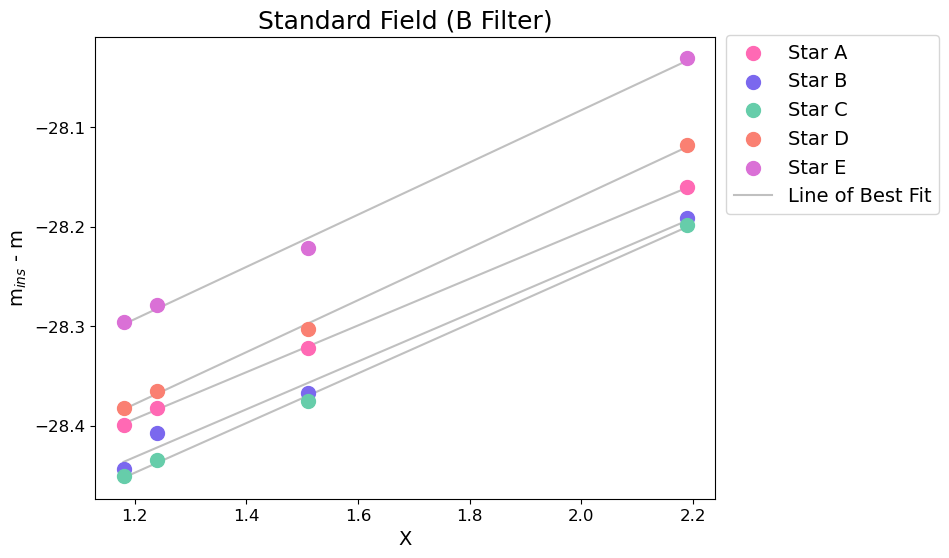

In [333]:
plt.figure(figsize=(8,6))
plt.scatter(dBf['X'], dmB_a, color='hotpink', label='Star A', s=100)
plt.plot(dBf['X'], B_m_lob_a(dBf['X']), color='silver', zorder=0)
plt.scatter(dBf['X'], dmB_b, color='mediumslateblue', label='Star B', s=100)
plt.plot(dBf['X'], B_m_lob_b(dBf['X']), color='silver', zorder=0)
plt.scatter(dBf['X'], dmB_c, color='mediumaquamarine', label='Star C', s=100)
plt.plot(dBf['X'], B_m_lob_c(dBf['X']), color='silver', zorder=0)
plt.scatter(dBf['X'], dmB_d, color='salmon', label='Star D', s=100)
plt.plot(dBf['X'], B_m_lob_d(dBf['X']), color='silver', zorder=0)
plt.scatter(dBf['X'], dmB_e, color='orchid', label='Star E', s=100)
plt.plot(dBf['X'], B_m_lob_e(dBf['X']), color='silver', zorder=0, label='Line of Best Fit')
plt.legend(fontsize=14, bbox_to_anchor=(1.001,1.024))
plt.title('Standard Field (B Filter)', fontsize=18)
plt.xlabel('X', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)

In [486]:
dBf

File     X      Center A      Center B      Center C      Center D  \
0  a083  1.18  (1047, 1044)  (1253, 1222)  (1365, 1232)  (1446, 1183)   
1  a133  1.24   (988, 1038)  (1196, 1216)  (1307, 1225)  (1387, 1176)   
2  a204  1.51   (982, 1031)  (1189, 1209)  (1301, 1219)  (1381, 1170)   
3  a239  2.19   (895, 1033)  (1102, 1211)  (1214, 1221)  (1294, 1172)   

      Center E        m_A        m_B        m_C        m_D        m_E  \
0  (991, 1051) -12.270041 -14.393406 -14.087794 -14.156491 -14.090461   
1  (933, 1044) -12.252872 -14.357545 -14.071940 -14.139413 -14.073308   
2  (926, 1037) -12.192463 -14.316931 -14.012608 -14.076455 -14.016222   
3  (839, 1040) -12.031471 -14.141432 -13.835443 -13.892236 -13.825067   

        K_A       K_B       K_C       K_D       K_E  
0  0.234867  0.240233  0.249689  0.261212  0.262529  
1  0.234867  0.240233  0.249689  0.261212  0.262529  
2  0.234867  0.240233  0.249689  0.261212  0.262529  
3  0.234867  0.240233  0.249689  0.261212  0.262529

## V Filter

In [340]:
dV = {'File': ['a086', 'a134', 'a206', 'a241'],
      'X': [1.18, 1.24, 1.52, 2.21],
      'Center A': [(1045,1044), (989,1038), (981,1032), (895,1034)],
      'Center B': [(1251,1222), (1196,1216), (1188,1210), (1102,1213)],
      'Center C': [(1364,1232), (1308,1226), (1300,1219), (1214,1222)],
      'Center D': [(1444,1182), (1388,1176), (1381,1170), (1294,1173)],
      'Center E': [(989,1050), (933,1044), (926.6,1038.2), (839,1040)]}

dVf = pd.DataFrame(dV)

In [341]:
V_a = m(df_=dVf, star='Center A', dir_=Vdir)
V_b = m(df_=dVf, star='Center B', dir_=Vdir)
V_c = m(df_=dVf, star='Center C', dir_=Vdir)
V_d = m(df_=dVf, star='Center D', dir_=Vdir)
V_e = m(df_=dVf, star='Center E', dir_=Vdir)

In [342]:
dmV_a = V_a - df_L['V mag'][0]
dmV_b = V_b - df_L['V mag'][1]
dmV_c = V_c - df_L['V mag'][2]
dmV_d = V_d - df_L['V mag'][3]
dmV_e = V_e - df_L['V mag'][4]

V_m_lob_a = fitter(model, dVf['X'], dmV_a)
V_m_lob_b = fitter(model, dVf['X'], dmV_b)
V_m_lob_c = fitter(model, dVf['X'], dmV_c)
V_m_lob_d = fitter(model, dVf['X'], dmV_d)
V_m_lob_e = fitter(model, dVf['X'], dmV_e) 

In [483]:
dVf['m_A'] = V_a
dVf['m_B'] = V_b
dVf['m_C'] = V_c
dVf['m_D'] = V_d
dVf['m_E'] = V_e

dVf['K_A'] = V_m_lob_a.slope[0]
dVf['K_B'] = V_m_lob_b.slope[0]
dVf['K_C'] = V_m_lob_c.slope[0]
dVf['K_D'] = V_m_lob_d.slope[0]
dVf['K_E'] = V_m_lob_e.slope[0]

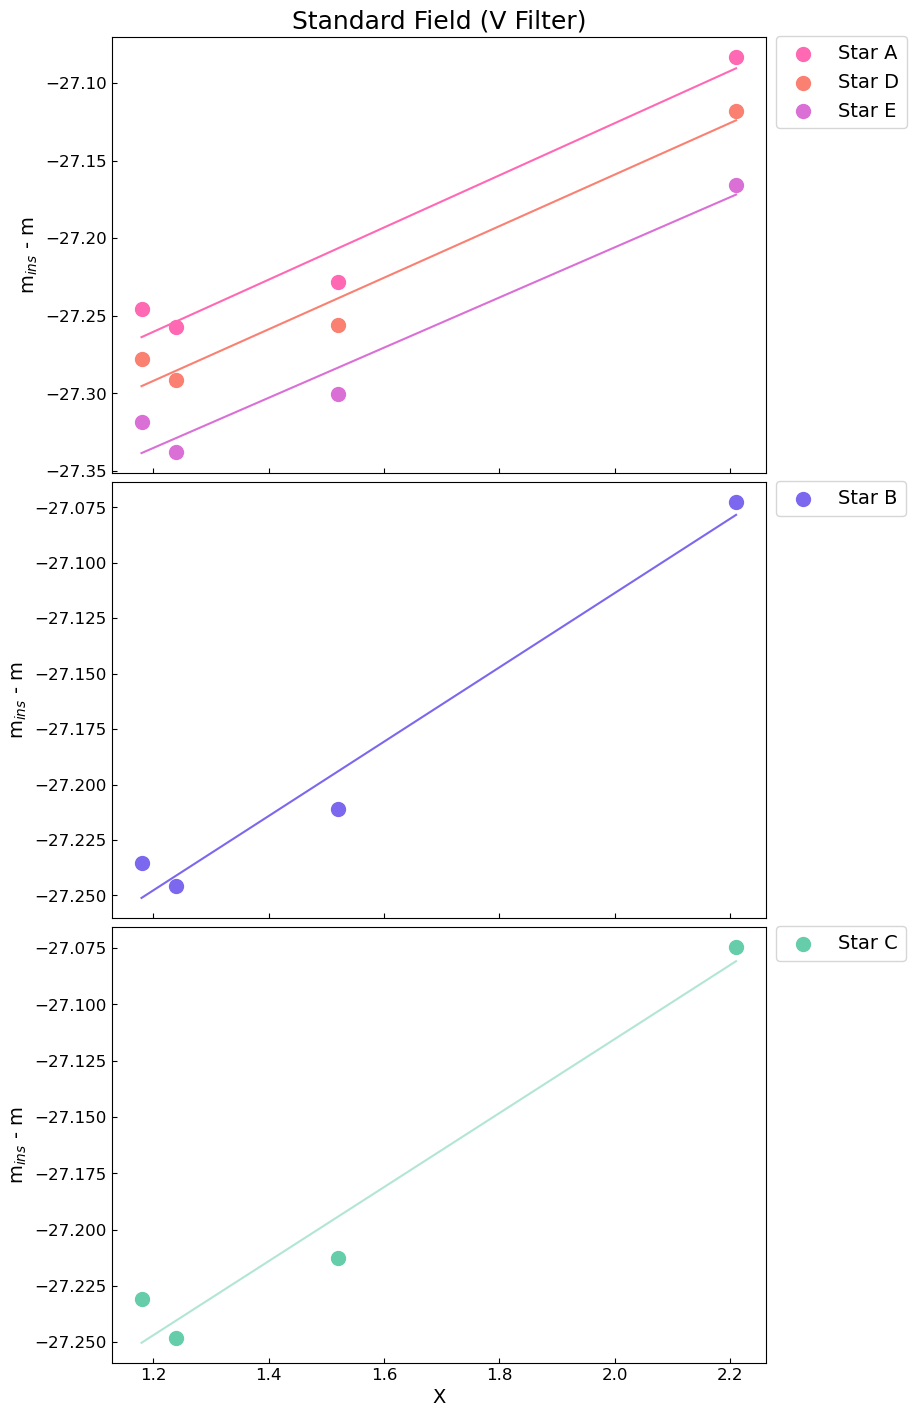

In [356]:
fig = plt.figure(figsize=(9,14))

p1 = fig.add_subplot(3,1,1)
plt.scatter(dVf['X'], dmV_a, color='hotpink', label='Star A', s=100)
plt.plot(dVf['X'], V_m_lob_a(dVf['X']), color='hotpink', zorder=0)
plt.scatter(dVf['X'], dmV_d, color='salmon', label='Star D', s=100)
plt.plot(dVf['X'], V_m_lob_d(dVf['X']), color='salmon', zorder=0)
plt.scatter(dVf['X'], dmV_e, color='orchid', label='Star E', s=100)
plt.plot(dVf['X'], V_m_lob_e(dVf['X']), color='orchid', zorder=0)
# plt.xlabel('X', fontsize=14)
plt.xticks(ticks=[1.2, 1.4, 1.6, 1.8, 2.0, 2.2], labels=['','','','','',''])
plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)
plt.title('Standard Field (V Filter)', fontsize=18)
plt.legend(fontsize=14, bbox_to_anchor=(1.001,1.024))
plt.tick_params(axis='both', tickdir='in')

p2 = fig.add_subplot(3,1,2)
plt.scatter(dVf['X'], dmV_b, color='mediumslateblue', label='Star B', s=100)
plt.plot(dVf['X'], V_m_lob_b(dVf['X']), color='mediumslateblue', zorder=0)
plt.xticks(ticks=[1.2, 1.4, 1.6, 1.8, 2.0, 2.2], labels=['','','','','',''])
plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, bbox_to_anchor=(1.001,1.024))
plt.tick_params(axis='both', tickdir='in')

p3 = fig.add_subplot(3,1,3)
plt.scatter(dVf['X'], dmV_c, color='mediumaquamarine', label='Star C', s=100)
plt.plot(dVf['X'], V_m_lob_c(dVf['X']), color='mediumaquamarine', zorder=0, alpha=0.5)
plt.xlabel('X', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)
plt.tick_params(axis='both', tickdir='in')

plt.legend(fontsize=14, bbox_to_anchor=(1.001,1.024))

plt.tight_layout(pad=0.1)

In [484]:
dVf

File     X      Center A      Center B      Center C      Center D  \
0  a086  1.18  (1045, 1044)  (1251, 1222)  (1364, 1232)  (1444, 1182)   
1  a134  1.24   (989, 1038)  (1196, 1216)  (1308, 1226)  (1388, 1176)   
2  a206  1.52   (981, 1032)  (1188, 1210)  (1300, 1219)  (1381, 1170)   
3  a241  2.21   (895, 1034)  (1102, 1213)  (1214, 1222)  (1294, 1173)   

          Center E        m_A        m_B        m_C        m_D        m_E  \
0      (989, 1050) -11.989839 -14.266297 -14.001775 -13.586879 -12.921499   
1      (933, 1044) -12.001281 -14.276733 -14.019109 -13.600620 -12.940773   
2  (926.6, 1038.2) -11.972118 -14.242188 -13.983532 -13.564870 -12.903437   
3      (839, 1040) -11.827185 -14.103490 -13.845286 -13.427017 -12.768746   

        K_A     K_B       K_C       K_D       K_E  
0  0.168161  0.1677  0.164569  0.166264  0.161681  
1  0.168161  0.1677  0.164569  0.166264  0.161681  
2  0.168161  0.1677  0.164569  0.166264  0.161681  
3  0.168161  0.1677  0.164569  0.166264  0.161681

## R Filter

In [363]:
dR = {'File': ['a088', 'a136', 'a209', 'a244'],
      'X': [1.18, 1.24, 1.53, 2.23],
      'Center A': [(1044,1044), (988,1039), (982,1032), (896.7,1034.2)],
      'Center B': df['Center B']['R'],
      'Center C': df['Center C']['R'],
      'Center D': df['Center D']['R'],
      'Center E': df['Center E']['R']}

dRf = pd.DataFrame(data=dR)

In [365]:
R_a = m(df_=dRf, star='Center A', dir_=Rdir)
R_b = m(df_=dRf, star='Center B', dir_=Rdir)
R_c = m(df_=dRf, star='Center C', dir_=Rdir)
R_d = m(df_=dRf, star='Center D', dir_=Rdir)
R_e = m(df_=dRf, star='Center E', dir_=Rdir)

In [366]:
dmR_a = R_a - df_L['R mag'][0]
dmR_b = R_b - df_L['R mag'][1]
dmR_c = R_c - df_L['R mag'][2]
dmR_d = R_d - df_L['R mag'][3]
dmR_e = R_e - df_L['R mag'][4]

R_m_lob_a = fitter(model, dRf['X'], dmR_a)
R_m_lob_b = fitter(model, dRf['X'], dmR_b)
R_m_lob_c = fitter(model, dRf['X'], dmR_c)
R_m_lob_d = fitter(model, dRf['X'], dmR_d)
R_m_lob_e = fitter(model, dRf['X'], dmR_e) 

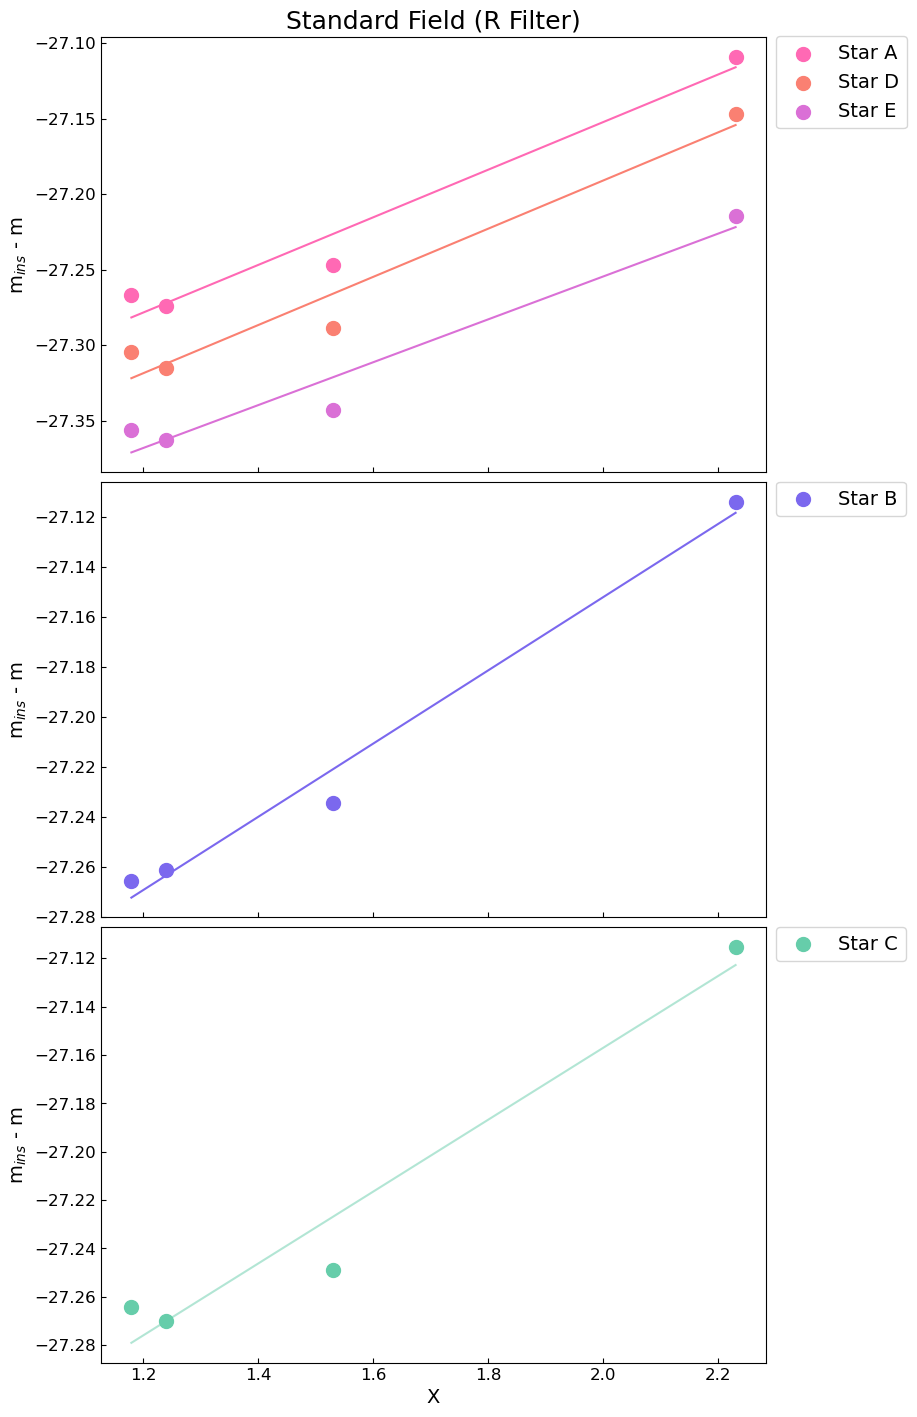

In [369]:
fig = plt.figure(figsize=(9,14))

p1 = fig.add_subplot(3,1,1)
plt.scatter(dRf['X'], dmR_a, color='hotpink', label='Star A', s=100)
plt.plot(dRf['X'], R_m_lob_a(dRf['X']), color='hotpink', zorder=0)
plt.scatter(dRf['X'], dmR_d, color='salmon', label='Star D', s=100)
plt.plot(dRf['X'], R_m_lob_d(dRf['X']), color='salmon', zorder=0)
plt.scatter(dRf['X'], dmR_e, color='orchid', label='Star E', s=100)
plt.plot(dRf['X'], R_m_lob_e(dRf['X']), color='orchid', zorder=0)
# plt.xlabel('X', fontsize=14)
plt.xticks(ticks=[1.2, 1.4, 1.6, 1.8, 2.0, 2.2], labels=['','','','','',''])
plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)
plt.title('Standard Field (R Filter)', fontsize=18)
plt.legend(fontsize=14, bbox_to_anchor=(1.001,1.024))
plt.tick_params(axis='both', tickdir='in')

p2 = fig.add_subplot(3,1,2)
plt.scatter(dRf['X'], dmR_b, color='mediumslateblue', label='Star B', s=100)
plt.plot(dRf['X'], R_m_lob_b(dRf['X']), color='mediumslateblue', zorder=0)
plt.xticks(ticks=[1.2, 1.4, 1.6, 1.8, 2.0, 2.2], labels=['','','','','',''])
plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=14, bbox_to_anchor=(1.001,1.024))
plt.tick_params(axis='both', tickdir='in')

p3 = fig.add_subplot(3,1,3)
plt.scatter(dRf['X'], dmR_c, color='mediumaquamarine', label='Star C', s=100)
plt.plot(dRf['X'], R_m_lob_c(dRf['X']), color='mediumaquamarine', zorder=0, alpha=0.5)
plt.xlabel('X', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)
plt.tick_params(axis='both', tickdir='in')

plt.legend(fontsize=14, bbox_to_anchor=(1.001,1.024))

plt.tight_layout(pad=0.1)

In [481]:
dRf['m_A'] = R_a
dRf['m_B'] = R_b
dRf['m_C'] = R_c
dRf['m_D'] = R_d
dRf['m_E'] = R_e

dRf['K_A'] = R_m_lob_a.slope[0]
dRf['K_B'] = R_m_lob_b.slope[0]
dRf['K_C'] = R_m_lob_c.slope[0]
dRf['K_D'] = R_m_lob_d.slope[0]
dRf['K_E'] = R_m_lob_e.slope[0]

In [482]:
dRf

File     X         Center A          Center B          Center C  \
0  a088  1.18     (1044, 1044)      (1250, 1222)      (1362, 1232)   
1  a136  1.24      (988, 1039)      (1196, 1217)      (1308, 1227)   
2  a209  1.53      (982, 1032)      (1189, 1209)      (1300, 1219)   
3  a244  2.23  (896.7, 1034.2)  (1102.5, 1212.5)  (1214.2, 1221.7)   

         Center D        Center E        m_A        m_B        m_C        m_D  \
0    (1443, 1182)     (988, 1050) -12.515651 -14.886562 -14.653322 -13.937471   
1    (1387, 1177)     (932, 1045) -12.522801 -14.882150 -14.659238 -13.947962   
2    (1381, 1170)     (926, 1038) -12.495816 -14.855217 -14.638019 -13.921467   
3  (1295, 1173.3)  (840, 1040.83) -12.358179 -14.735048 -14.504465 -13.779667   

         m_E       K_A       K_B       K_C       K_D       K_E  
0 -12.866301  0.157757  0.146573  0.148831  0.159631  0.142065  
1 -12.872715  0.157757  0.146573  0.148831  0.159631  0.142065  
2 -12.853172  0.157757  0.146573  0.148831  0.159631  0.142065  
3 -12.724586  0.157757  0.146573  0.148831  0.159631  0.142065

## I Filter

In [370]:
dI = {'File': df['File']['I'],
      'X': df['X']['I'],
      'Center A': df['Center A']['I'],
      'Center B': df['Center B']['I'],
      'Center C': df['Center C']['I'],
      'Center D': df['Center D']['I'],
      'Center E': df['Center E']['I']}

dIf = pd.DataFrame(data=dI)

In [372]:
I_a = m(df_=dIf, star='Center A', dir_=Idir)
I_b = m(df_=dIf, star='Center B', dir_=Idir)
I_c = m(df_=dIf, star='Center C', dir_=Idir)
I_d = m(df_=dIf, star='Center D', dir_=Idir)
I_e = m(df_=dIf, star='Center E', dir_=Idir)

In [468]:
dIf['m_A'] = I_a
dIf['m_B'] = I_b
dIf['m_C'] = I_c
dIf['m_D'] = I_d
dIf['m_E'] = I_e

In [373]:
dmI_a = I_a - df_L['I mag'][0]
dmI_b = I_b - df_L['I mag'][1]
dmI_c = I_c - df_L['I mag'][2]
dmI_d = I_d - df_L['I mag'][3]
dmI_e = I_e - df_L['I mag'][4]

I_m_lob_a = fitter(model, dIf['X'], dmI_a)
I_m_lob_b = fitter(model, dIf['X'], dmI_b)
I_m_lob_c = fitter(model, dIf['X'], dmI_c)
I_m_lob_d = fitter(model, dIf['X'], dmI_d)
I_m_lob_e = fitter(model, dIf['X'], dmI_e) 

In [479]:
dIf['K_A'] = I_m_lob_a.slope[0]
dIf['K_B'] = I_m_lob_b.slope[0]
dIf['K_C'] = I_m_lob_c.slope[0]
dIf['K_D'] = I_m_lob_d.slope[0]
dIf['K_E'] = I_m_lob_e.slope[0]

Text(0.5, 0.98, 'Standard Field (I Filter)')

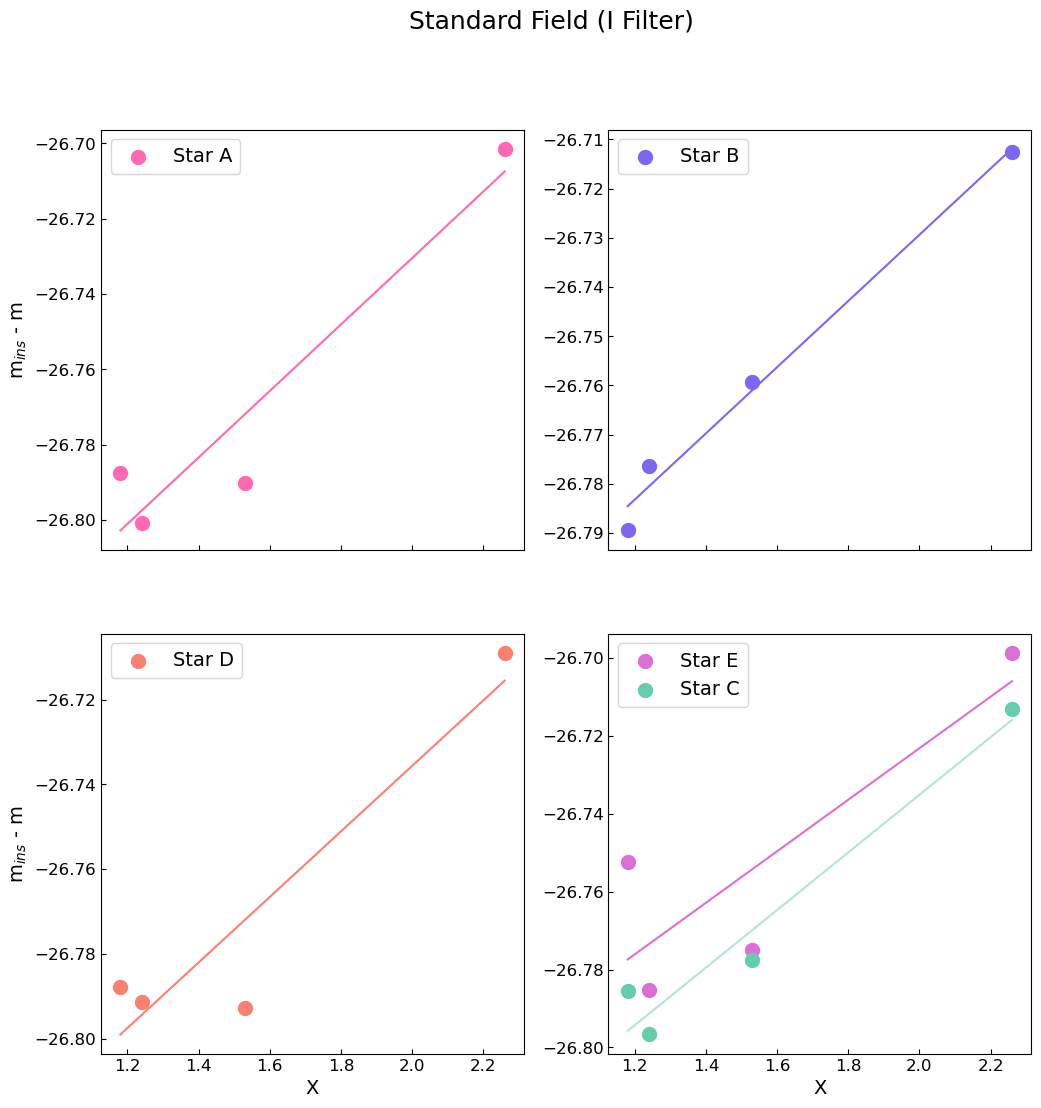

In [381]:
fig = plt.figure(figsize=(12,12))

p1 = fig.add_subplot(2,2,1)
plt.scatter(dIf['X'], dmI_a, color='hotpink', label='Star A', s=100)
plt.plot(dIf['X'], I_m_lob_a(dIf['X']), color='hotpink', zorder=0)
plt.xticks(ticks=[1.2, 1.4, 1.6, 1.8, 2.0, 2.2], labels=['','','','','',''])
plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.tick_params(axis='both', tickdir='in')

p2 = fig.add_subplot(2,2,2)
plt.scatter(dIf['X'], dmI_b, color='mediumslateblue', label='Star B', s=100)
plt.plot(dIf['X'], I_m_lob_b(dIf['X']), color='mediumslateblue', zorder=0)
plt.xticks(ticks=[1.2, 1.4, 1.6, 1.8, 2.0, 2.2], labels=['','','','','',''])
# plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.tick_params(axis='both', tickdir='in')

p3 = fig.add_subplot(2,2,3)
plt.scatter(dIf['X'], dmI_d, color='salmon', label='Star D', s=100)
plt.plot(dIf['X'], I_m_lob_d(dIf['X']), color='salmon', zorder=0)
# plt.scatter(dIf['X'], dmI_c, color='mediumaquamarine', label='Star C', s=100)
# plt.plot(dIf['X'], I_m_lob_c(dIf['X']), color='mediumaquamarine', zorder=0, alpha=0.5)
plt.xlabel('X', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('m$_{ins}$ - m', fontsize=14)
plt.yticks(fontsize=12)
plt.tick_params(axis='both', tickdir='in')
plt.legend(fontsize=14)

p4 = fig.add_subplot(2,2,4)
# plt.scatter(dIf['X'], dmI_d, color='salmon', label='Star D', s=100)
# plt.plot(dIf['X'], I_m_lob_d(dIf['X']), color='salmon', zorder=0)
plt.scatter(dIf['X'], dmI_e, color='orchid', label='Star E', s=100)
plt.plot(dIf['X'], I_m_lob_e(dIf['X']), color='orchid', zorder=0)
plt.scatter(dIf['X'], dmI_c, color='mediumaquamarine', label='Star C', s=100)
plt.plot(dIf['X'], I_m_lob_c(dIf['X']), color='mediumaquamarine', zorder=0, alpha=0.5)
plt.xlabel('X', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(axis='both', tickdir='in')
plt.legend(fontsize=14)

plt.suptitle('Standard Field (I Filter)', fontsize=18)

In [480]:
dIf

File     X           Center A           Center B         Center C  \
0  a089  1.18       (1042, 1045)       (1249, 1223)     (1362, 1233)   
1  a139  1.24        (987, 1040)       (1194, 1218)     (1306, 1228)   
2  a211  1.53  (980.83, 1033.33)  (1187.5, 1210.83)  (1300, 1220.83)   
3  a245  2.26        (895, 1035)       (1102, 1213)     (1214, 1223)   

          Center D        Center E        m_A        m_B        m_C  \
0     (1442, 1184)     (987, 1051) -12.546431 -14.910490 -14.694477   
1     (1386, 1179)     (931, 1046) -12.559720 -14.897449 -14.705683   
2  (1380, 1171.67)  (925, 1039.17) -12.549093 -14.880390 -14.686644   
3     (1294, 1174)     (839, 1042) -12.460464 -14.833649 -14.622081   

         m_D        m_E       K_A       K_B       K_C       K_D       K_E  
0 -13.746821 -12.143367  0.088185  0.067273  0.073963  0.077339  0.066168  
1 -13.750340 -12.176209  0.088185  0.067273  0.073963  0.077339  0.066168  
2 -13.751898 -12.165869  0.088185  0.067273  0.073963  0.077339  0.066168  
3 -13.667921 -12.089617  0.088185  0.067273  0.073963  0.077339  0.066168

In [ ]:
X_df = {'K': }

# 6) Find color term

- I am finding **V-Vo = Co_V + C1_V(B-V)** where V is the y-intercept from the V-filter line-of-best fit from step 5 and Vo is the accepted V magnitude

- I'm also finding **R-Ro = Co_R + C1_R(V-R)** where R is the y-intercept from the R-filter line-of-best fit from step 5 and Ro is the accepted R magnitude

In [392]:
V_int = np.array([V_m_lob_a.intercept[0], V_m_lob_b.intercept[0], V_m_lob_c.intercept[0],
                V_m_lob_d.intercept[0], V_m_lob_e.intercept[0]])

R_int = np.array([R_m_lob_a.intercept[0], R_m_lob_b.intercept[0], R_m_lob_c.intercept[0],
                R_m_lob_d.intercept[0], R_m_lob_e.intercept[0]])

In [393]:
df_L

Star   U mag   B mag   V mag   R mag   I mag  B - V  U - B  V - R  R - I  \
0    A  16.449  16.129  15.256  14.751  14.241  0.873  0.320  0.505  0.511   
1    B  15.057  14.050  12.969  12.379  11.879  1.081  1.007  0.590  0.502   
2    C  15.501  14.363  13.229  12.611  12.091  1.134  1.138  0.618  0.523   
3    D  14.201  14.226  13.691  13.367  13.041  0.535 -0.025  0.324  0.327   
4    E  13.231  14.205  14.397  14.490  14.609 -0.192 -0.974 -0.093 -0.116   

   V - I  
0  1.015  
1  1.090  
2  1.138  
3  0.650  
4 -0.212

In [398]:
lob_B_V = fitter(model, df_L['B - V'], V_int-df_L['V mag'])
lob_V_R = fitter(model, df_L['V - R'], R_int-df_L['R mag'])

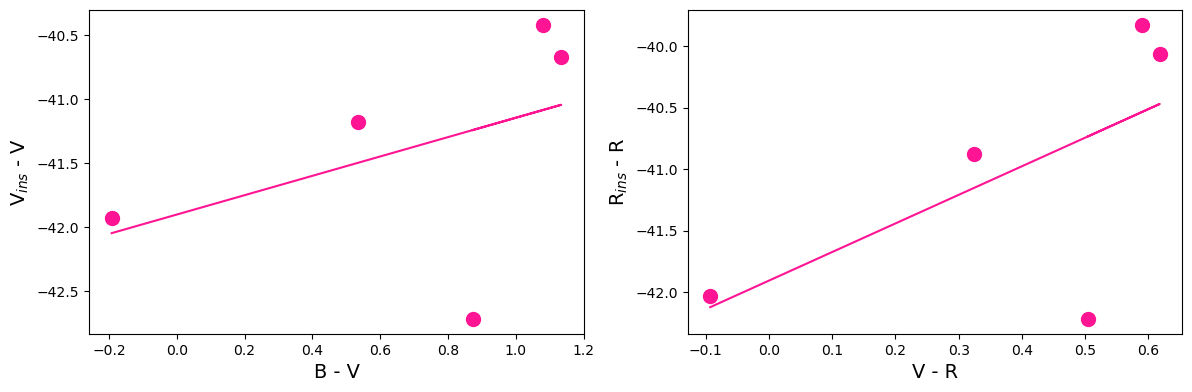

In [405]:
fig = plt.figure(figsize=(12,4))

p1 = fig.add_subplot(1,2,1)
plt.scatter(df_L['B - V'], V_int-df_L['V mag'], color='deeppink', s=100)
plt.plot(df_L['B - V'], lob_B_V(df_L['B - V']), color='deeppink')
plt.xlabel('B - V', fontsize=14)
plt.ylabel('V$_{ins}$ - V', fontsize=14)

p2 = fig.add_subplot(1,2,2)
plt.scatter(df_L['V - R'], R_int-df_L['R mag'], color='deeppink', s=100)
plt.plot(df_L['V - R'], lob_V_R(df_L['V - R']), color='deeppink')
plt.xlabel('V - R', fontsize=14)
plt.ylabel('R$_{ins}$ - R', fontsize=14)

plt.tight_layout(pad=1)

In [478]:
print(lob_B_V)
print(lob_V_R)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    0.7558935891743979 -41.90235355468597
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope           intercept     
    ----------------- ------------------
    2.323919101466915 -41.90648114846444


And now for R - I because that's the color I'm using for #7

In [426]:
lob_R_I = fitter(model, df_L['R - I'], R_int-df_L['R mag'])

Text(0, 0.5, 'R$_{ins}$ - R')

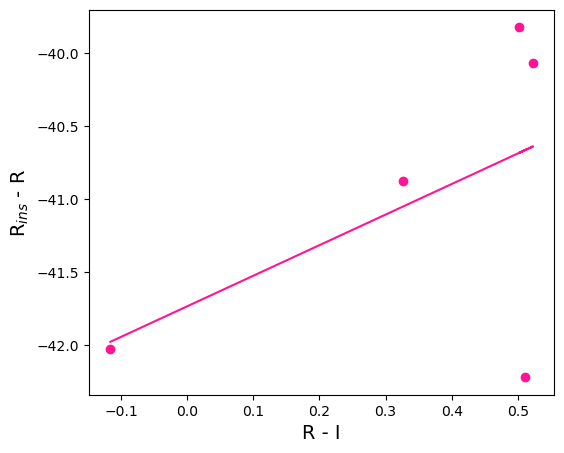

In [471]:
fig = plt.figure(figsize=(6,5))
plt.scatter(df_L['R - I'], R_int-df_L['R mag'], color='deeppink')
plt.plot(df_L['R - I'], lob_R_I(df_L['R - I']), color='deeppink')
plt.xlabel('R - I', fontsize=14)
plt.ylabel('R$_{ins}$ - R', fontsize=14)

In [489]:
dict_color = {'Co': [lob_B_V.intercept[0], lob_V_R.intercept[0], lob_R_I.intercept[0]],
            'C1': [lob_B_V.slope[0], lob_V_R.slope[0], lob_R_I.slope[0]]}

df_color = pd.DataFrame(dict_color, index=['B - V', 'V - R', 'R - I'])

In [490]:
df_color

Co        C1
B - V -41.902354  0.755894
V - R -41.906481  2.323919
R - I -41.733992  2.092304

# 7) NGC6823

### **End Goal:** R vs R-I plot

In [406]:
from photutils.detection import DAOStarFinder

Testing out DAOStarFinder on a153otzf.fits

In [419]:
a153 = fits.open(Idir+'a153otzf.fits')
avg_153, med_153, std_153 = sigma_clipped_stats(a153[0].data, sigma=3.0)  
print((avg_153, med_153, std_153))  

(37.737919511393414, 37.47745265357722, 9.03653353184353)


In [420]:
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std_153)  
sources = daofind(a153[0].data - med_153)

for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)  

 id  xcentroid ycentroid sharpness roundness1 ... sky   peak  flux  mag 
---- --------- --------- --------- ---------- ... ---- ------ ---- -----
   1   1416.91      2.87      0.50      -0.78 ... 0.00 204.25 3.59 -1.39
   2     94.83      7.40      0.28      -0.61 ... 0.00  50.36 1.24 -0.23
   3   1287.29      7.97      0.52      -0.99 ... 0.00 507.80 7.92 -2.25
   4   1130.59      8.94      0.59      -0.95 ... 0.00 250.89 3.97 -1.50
   5   1644.70     11.61      0.43      -0.79 ... 0.00  82.05 1.73 -0.60
   6   1778.62     11.31      0.50      -0.54 ... 0.00  77.04 1.19 -0.19
   7     73.39     14.96      0.49      -0.63 ... 0.00 205.32 3.62 -1.40
   8    912.99     16.84      0.56      -0.41 ... 0.00  60.18 1.09 -0.09
   9   1836.11     19.25      0.21       0.23 ... 0.00  42.88 1.11 -0.11
  10   1068.19     19.68      0.44      -0.25 ... 0.00 266.83 4.50 -1.63
 ...       ...       ...       ...        ... ...  ...    ...  ...   ...
1374    582.73   2033.04      0.54      -0.03 ... 0

 ...]

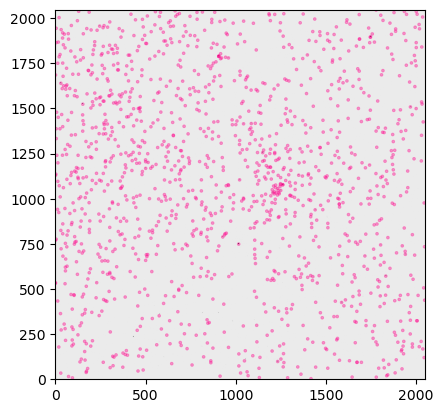

In [421]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(a153[0].data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='deeppink', lw=1.5, alpha=0.5)

Ok cool! Now I will do the same for a156otzf.fits since that image was taken in the R filter. Airmass is X = 1.10

In [422]:
a156 = fits.open(Rdir+'a156otzf.fits')
avg_156, med_156, std_156 = sigma_clipped_stats(a156[0].data, sigma=3.0)
daofind_156 = DAOStarFinder(fwhm=3.0, threshold=5.*std_156)  
sources_156 = daofind_156(a156[0].data - med_156)

for col in sources_156.colnames:  
    if col not in ('id', 'npix'):
        sources_156[col].info.format = '%.2f'  # for consistent table output
sources_156.pprint(max_width=76)

 id  xcentroid ycentroid sharpness roundness1 ... sky   peak   flux  mag 
---- --------- --------- --------- ---------- ... ---- ------ ----- -----
   1    931.82     -0.01      1.00      -0.36 ... 0.00 670.44 12.05 -2.70
   2    143.13      2.45      0.20      -0.07 ... 0.00  -0.84  1.06 -0.06
   3     67.95      5.59      0.38      -0.71 ... 0.00  16.67  1.06 -0.07
   4    771.55      6.76      0.29      -0.41 ... 0.00   6.41  1.13 -0.13
   5   1859.53      6.83      0.44      -0.81 ... 0.00  13.28  1.01 -0.01
   6     67.02      6.87      0.40      -0.62 ... 0.00  19.18  1.13 -0.13
   7    649.32      7.54      0.39      -0.63 ... 0.00  10.13  1.03 -0.03
   8   1130.07      8.56      0.46      -0.52 ... 0.00 176.77  3.19 -1.26
   9   1511.05     10.14      0.34      -0.49 ... 0.00   5.02  1.22 -0.21
  10    761.93      9.29      0.27      -0.07 ... 0.00   7.53  1.15 -0.15
 ...       ...       ...       ...        ... ...  ...    ...   ...   ...
1053   1183.27   2025.48      0.51    

 ...]

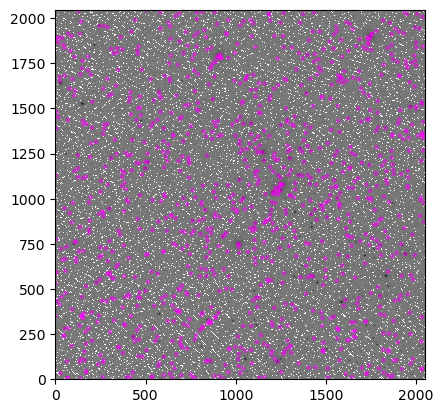

In [477]:
positions = np.transpose((sources_156['xcentroid'], sources_156['ycentroid']))
apertures = CircularAperture(positions, r=7.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(a156[0].data, cmap='Greys', origin='lower',
           interpolation='nearest', norm=colors.LogNorm())
apertures.plot(color='magenta', lw=1.5, alpha=0.5)

Now, I'm going to find the accepted R magnitudes (R_acc) using the dRmag = kX line of best fit. Specifically, I am using the LOB of Star B since plots show that it has less scatter than the rest.

In [425]:
dRmag = R_m_lob_b(1.1)
Racc = sources_156['mag'] - dRmag

Now I'm gonna use the dRmag vs. R - I line of best fit derived from Star B to find the true R - I color

In [431]:
lob_R_I

<Linear1D(slope=2.09230402, intercept=-41.73399243)>

In [432]:
R_zeroX = R_m_lob_b.intercept[0]
ngc_RI = (R_zeroX - lob_R_I.intercept[0] - Racc)/lob_R_I.slope[0]

Text(0.5, 1.0, 'NGC6823 (a156otzf.fits)')

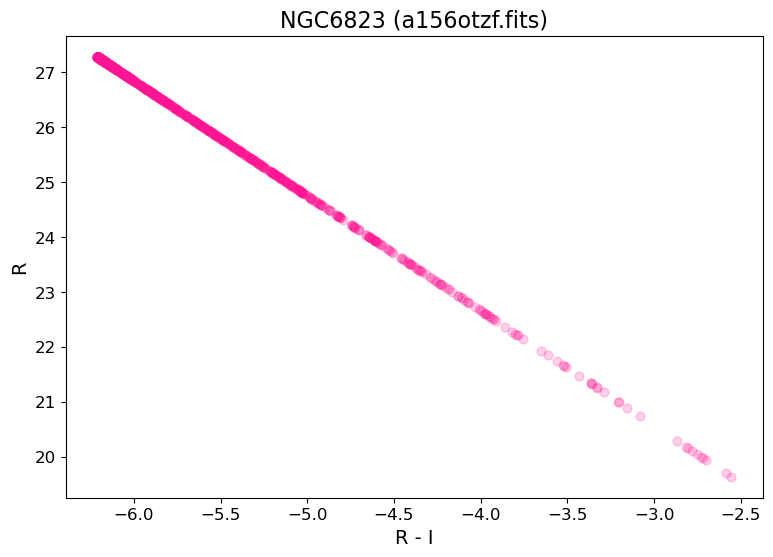

In [439]:
plt.figure(figsize=(9,6))
plt.scatter(ngc_RI, Racc, s=40, color='deeppink', alpha=0.2)
plt.xlabel('R - I', fontsize=14)
plt.ylabel('R', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('NGC6823 (a156otzf.fits)', fontsize=16)